# Técnicas de Machine Learning
## Análise de dados da quantidade de bicicletas que serão alugadas em Seoul (Coreia do Sul) em 2019
### ATIVIDADE SOMATIVA 1 - Semana 4

### Curso: Análise e Desenvolvimento de Sistemas
### Autor: Matheus Vinicyus Strada

<hr/>

## Importação da bibliotecas utilizadas

In [1]:
# Para manipulação e análise de dados
import pandas as pd
import numpy as np

# Para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Para dividir os dados em conjuntos de treino e teste
from sklearn.model_selection import train_test_split

# Algoritmo de Machine Learning que utilizaremos (LightGBM)
from lightgbm import LGBMRegressor

# Para avaliar a performance do nosso modelo
from sklearn.metrics import mean_squared_error, r2_score

# Configurações para melhorar a visualização dos gráficos
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Carregamento do dataset, e alguns dados de visualização

In [2]:
# Carregando o dataset a partir do arquivo Excel
try:
  df = pd.read_excel('seoul_bike_data.xlsx')
except FileNotFoundError:
  # Caso o arquivo não seja encontrado, criamos um DataFrame com os dados de exemplo fornecidos
  print("Arquivo 'seoul_bike_data.xlsx' não encontrado.")

# Exibindo as 5 primeiras linhas do dataset
print("### 5 Primeiras Linhas do Dataset ###")
display(df.head())

# Exibindo informações gerais sobre as colunas
print("\n### Informações Gerais do Dataset ###")
df.info()

# Exibindo um resumo estatístico das colunas numéricas
print("\n### Resumo Estatístico ###")
display(df.describe())
    

### 5 Primeiras Linhas do Dataset ###


,DateTime,Day,Weekday,Hour,Rented Bike Count,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
0,2017-01-12 00:00:00,12,5,0,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0
1,2017-01-12 01:00:00,12,5,1,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0
2,2017-01-12 02:00:00,12,5,2,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0
3,2017-01-12 03:00:00,12,5,3,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0
4,2017-01-12 04:00:00,12,5,4,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0



### Informações Gerais do Dataset ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DateTime                   8760 non-null   object 
 1   Day                        8760 non-null   int64  
 2   Weekday                    8760 non-null   int64  
 3   Hour                       8760 non-null   int64  
 4   Rented Bike Count          8760 non-null   int64  
 5   Temperature(°C)            8760 non-null   float64
 6   Humidity(%)                8760 non-null   int64  
 7   Wind speed (m/s)           8760 non-null   float64
 8   Visibility (10m)           8760 non-null   int64  
 9   Dew point temperature(°C)  8760 non-null   float64
 10  Solar Radiation (MJ/m2)    8760 non-null   float64
 11  Rainfall(mm)               8760 non-null   float64
 12  Snowfall (cm)              8760 non-null   float64
dtypes: float6

,Day,Weekday,Hour,Rented Bike Count,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,15.720548,3.980822,11.500000,704.602055,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,8.796749,2.004811,6.922582,644.997468,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,1.000000,1.000000,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,8.000000,2.000000,5.750000,191.000000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,16.000000,4.000000,11.500000,504.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,23.000000,6.000000,17.250000,1065.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,31.000000,7.000000,23.000000,3556.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


TTT

In [3]:
# Passo 1: Garantir que a coluna 'DateTime' esteja no formato de data.
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Passo 2: Criar as novas colunas a partir da coluna 'DateTime'.
df['Year'] = df['DateTime'].dt.year
df['Month'] = df['DateTime'].dt.month

# Passo 3: Remover (dropar) a coluna 'DateTime' original.
df = df.drop('DateTime', axis=1)

# Visualizar o dataset após as modificações
print("\n### Dataset Após Modificações ###")
display(df.head())


### Dataset Após Modificações ###


,Day,Weekday,Hour,Rented Bike Count,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Year,Month
0,12,5,0,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,2017,1
1,12,5,1,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,2017,1
2,12,5,2,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,2017,1
3,12,5,3,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,2017,1
4,12,5,4,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,2017,1


TTEE

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1507
[LightGBM] [Info] Number of data points in the train set: 8760, number of used features: 11
[LightGBM] [Info] Start training from score 11.500000
### Importância de Cada Atributo ###


,feature,importance
0,Temperature_C,580
1,Humidity_pct,480
5,Solar_Radiation_MJ_m2,315
2,Wind_speed_ms,313
6,Rainfall_mm,271
4,Dew_point_temp_C,261
3,Visibility_10m,247
9,Month,219
10,DayOfWeek,180
7,Snowfall_cm,77


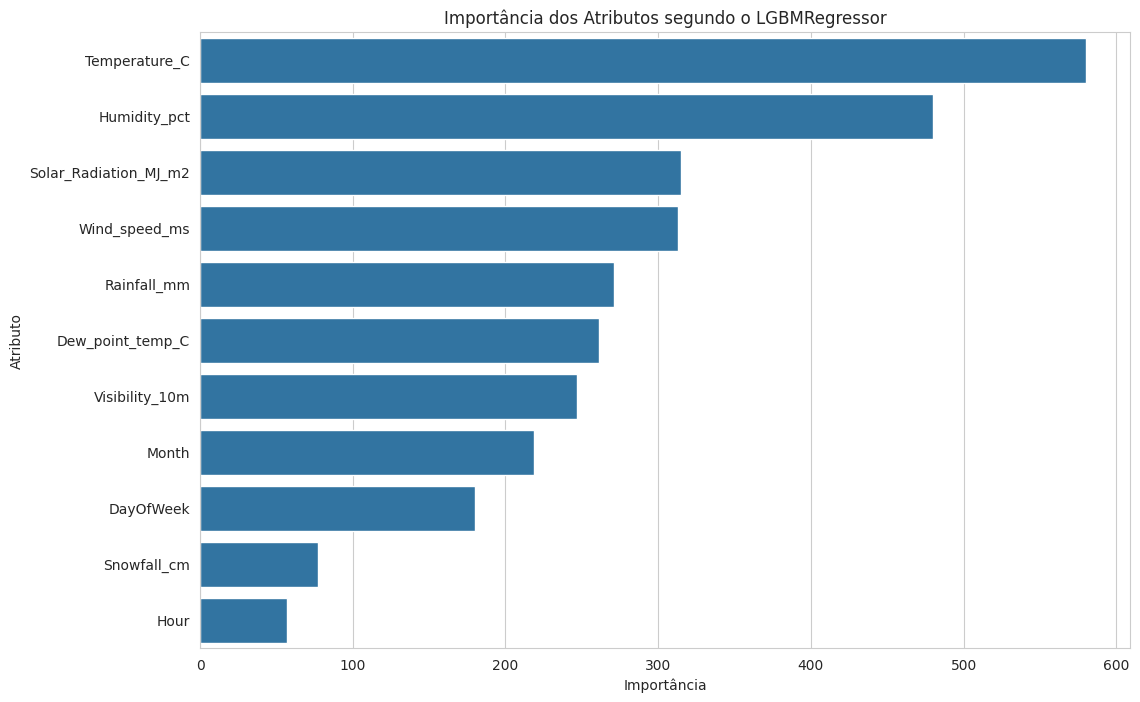


Atributos removidos: ['Dew_point_temp_C', 'Snowfall_cm', 'Wind_speed_ms']
Shape do nosso conjunto de atributos ANTES da seleção: (8760, 11)
Shape do nosso conjunto de atributos DEPOIS da seleção: (8760, 8)


In [12]:
# Separando as variáveis independentes (X) da variável dependente (y)
X = df_prepared.drop('Rented_Bike_Count', axis=1)
y = df_prepared['Rented_Bike_Count']

# Treinando um modelo preliminar para extrair a importância das features
feature_selector_model = LGBMRegressor(random_state=42)
feature_selector_model.fit(X, y)

# Criando um DataFrame com a importância de cada feature
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_selector_model.feature_importances_
}).sort_values('importance', ascending=False)

print("### Importância de Cada Atributo ###")
display(feature_importances)

# Plotando a importância das features para melhor visualização
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Importância dos Atributos segundo o LGBMRegressor')
plt.xlabel('Importância')
plt.ylabel('Atributo')
plt.show()

# Selecionando as features mais importantes. Vamos remover as de menor importância.
# A partir do gráfico, 'Snowfall_cm' e 'Wind_speed_ms' têm baixa importância.
# Além disso, para lidar com a multicolinearidade, vamos remover 'Dew_point_temp_C',
# já que 'Temperature_C' é mais importante e altamente correlacionada.
features_to_drop = ['Dew_point_temp_C', 'Snowfall_cm', 'Wind_speed_ms']
X_selected = X.drop(columns=features_to_drop)

print(f"\nAtributos removidos: {features_to_drop}")
print("Shape do nosso conjunto de atributos ANTES da seleção:", X.shape)
print("Shape do nosso conjunto de atributos DEPOIS da seleção:", X_selected.shape)

TTT

In [13]:
# Utilizando o dataset com os atributos já selecionados (X_selected)
# A variável alvo (y) permanece a mesma.
X_train, X_test, y_train, y_test = train_test_split(
    X_selected,
    y,
    test_size=0.25, # 25% dos dados para teste, conforme solicitado
    random_state=42 # random_state garante que a divisão seja sempre a mesma, para reprodutibilidade
)

print("Divisão dos dados concluída:")
print("Tamanho da base de treinamento (X_train):", X_train.shape)
print("Tamanho da base de teste (X_test):", X_test.shape)
print("Tamanho do alvo de treinamento (y_train):", y_train.shape)
print("Tamanho do alvo de teste (y_test):", y_test.shape)

Divisão dos dados concluída:
Tamanho da base de treinamento (X_train): (6570, 8)
Tamanho da base de teste (X_test): (2190, 8)
Tamanho do alvo de treinamento (y_train): (6570,)
Tamanho do alvo de teste (y_test): (2190,)


TTR

In [14]:
# 1. Instanciar o modelo
# Usaremos parâmetros básicos por enquanto. Na Parte II, poderíamos otimizá-los.
lgbm = LGBMRegressor(random_state=42)

# 2. Treinar o modelo
# O método .fit() "ensina" o modelo usando os dados de treinamento.
print("Iniciando o treinamento do modelo LGBMRegressor...")
lgbm.fit(X_train, y_train)
print("Treinamento concluído com sucesso!")

Iniciando o treinamento do modelo LGBMRegressor...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1130
[LightGBM] [Info] Number of data points in the train set: 6570, number of used features: 8
[LightGBM] [Info] Start training from score 11.498326
Treinamento concluído com sucesso!


teste

Realizando predições na base de teste...

### Avaliação do Modelo ###
Raiz do Erro Quadrático Médio (RMSE): 4.68
Coeficiente de Determinação (R²): 0.5547


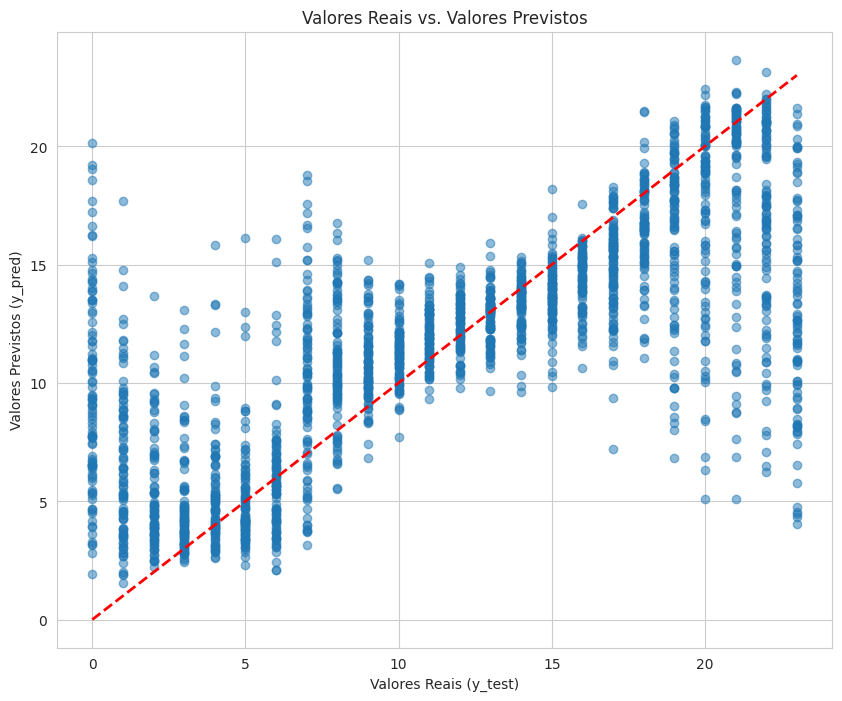


### Comparação de Valores Reais e Previstos (Amostra) ###


,Valor Real,Valor Previsto
6056,8,10.357571
5556,12,13.746239
5990,14,12.528418
7674,18,18.861172
3319,7,12.504297
5761,1,6.847509
5972,20,11.769813
8758,22,16.779182
6079,7,10.295226
7177,1,3.415667


In [15]:
# Realizando a predição na base de teste (dados que o modelo nunca viu)
print("Realizando predições na base de teste...")
y_pred = lgbm.predict(X_test)

# Avaliando o modelo com duas métricas comuns para regressão:
# - Raiz do Erro Quadrático Médio (RMSE): Mede a magnitude média dos erros. Quanto menor, melhor.
# - Coeficiente de Determinação (R²): Indica a porcentagem da variação da variável alvo que é explicada pelo modelo. Varia de 0 a 1. Quanto mais perto de 1, melhor.

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n### Avaliação do Modelo ###")
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse:.2f}")
print(f"Coeficiente de Determinação (R²): {r2:.4f}")

# Para uma análise visual, vamos criar um gráfico de dispersão
# comparando os valores reais com os valores previstos pelo modelo.
# Em um modelo perfeito, todos os pontos estariam sobre a linha vermelha.
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Valores Reais (y_test)')
plt.ylabel('Valores Previstos (y_pred)')
plt.title('Valores Reais vs. Valores Previstos')
plt.show()

# Vamos também criar um DataFrame para comparar alguns valores
comparison_df = pd.DataFrame({'Valor Real': y_test, 'Valor Previsto': y_pred})
print("\n### Comparação de Valores Reais e Previstos (Amostra) ###")
display(comparison_df.head(10))

TTTR